In [1]:
import numpy as np
import torch
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch_geometric.data import Dataset
from torch_geometric.utils import to_dense_adj
from torch_geometric.nn import MessagePassing
from torch_geometric.nn.aggr import SumAggregation
import matplotlib.pyplot as plt
import matplotlib as mpl
np.random.seed(0)
torch.manual_seed(0)

data = np.load('dataset_for_exercise_63/pyroxene.npz')

In [2]:
map_z_to_seq = {8: 0, 12: 1, 14: 2}
num_unique_attributes = len(map_z_to_seq)
embedding_dim = 4
embedding_layer = torch.nn.Embedding(num_unique_attributes, embedding_dim)

In [5]:
def get_graph(index, cutoff=3.5, box_size=10):

    positions = data['positions'][index]
    positions = torch.vstack([torch.tensor(p,dtype=torch.float32) for p in positions])
    D = torch.cdist(positions, positions)

    edge_index = []
    edge_attr = []
    for i in range(D.shape[0]):
        for j in range(D.shape[1]):
            if i == j:
                continue
            if D[i, j] < cutoff:
                edge_index.append([i, j])
                edge_attr.append(1)

    edge_index = torch.tensor(np.array(edge_index).T, dtype=torch.int64).reshape(2, -1)
    edge_attr = torch.tensor(edge_attr, dtype=torch.float32).view(-1, 1)
    z = torch.tensor(data['z_vals'][index],dtype=torch.float32)
    y = torch.tensor(data['energies'][index],dtype=torch.float32)
    x = embedding_layer(torch.tensor([map_z_to_seq[int(one_z)] for one_z in z])).detach()
    
    return Data(edge_index=edge_index, pos=positions, x=x, y=y, z=z, edge_attr=edge_attr)

colors = {
8: '#ff0d0d',
12: '#89ff00',
14: '#efc79f'
}
rs = {8: 0.35, 12: 0.8, 14: 0.5}

def plot_graph(ax, graph,  val_min=-1.5, val_max=1.5):
    positions = graph.pos.detach().numpy()

    # Plot the nodes:
    theta = np.linspace(0, 2*np.pi, 100)
    x = np.cos(theta)
    y = np.sin(theta)
    for idx, pos in enumerate(positions):
        z = graph.z[idx].item()
        r = rs[z]
        ax.plot(pos[0]+r*x, pos[1]+r*y, c='black')
        ax.fill_between(pos[0]+r*x, pos[1]+r*y, pos[1], color=colors[z])
        if hasattr(graph,'x') and graph.x is not None:
            box_x = pos[0] + 0.3
            box_y = pos[1] + 0.3
            for i, value in enumerate(graph.x[idx]):
                c = min(1,max(0, (value.item() - val_min) / (val_max - val_min)))
                rect = mpl.patches.Rectangle(
                    (box_x, box_y - i * 0.25),  # Position
                    0.25, 0.25,  # Width, Height
                    color=str(c),  # Grayscale color
                    ec='black',
                    zorder=10
                )
                ax.add_patch(rect)
    
    # Plot the edges:
    for idx, (edge, attr) in enumerate(zip(graph.edge_index.T, graph.edge_attr)):
        source = positions[edge[0]]
        target = positions[edge[1]]
        linewidth = 3 if attr.item() > 0.1 else 0.5
        ax.plot([source[0], target[0]], [source[1], target[1]], c='black', zorder=0, linewidth=linewidth)

    ax.axis('equal')
    ax.set_xticks([])
    ax.set_yticks([])
    if graph.y is not None:
        ax.text(0.05,0.05,f'{graph.y.item():.2f}',ha='left',va='bottom',transform=ax.transAxes,backgroundcolor='lightcyan')


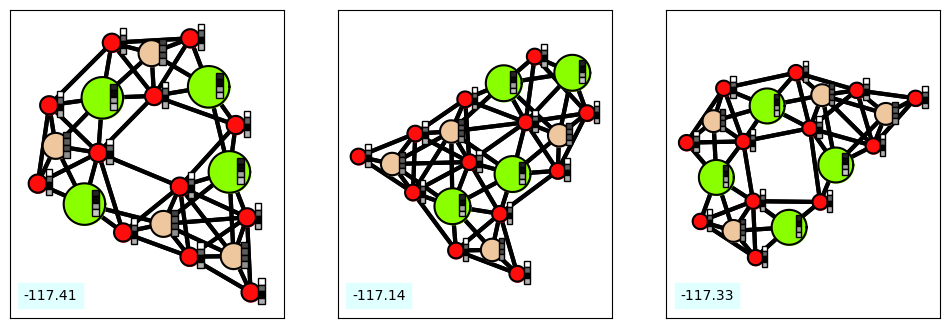

In [6]:
Ncol = 3
fig, axes = plt.subplots(1, Ncol, figsize=(Ncol*4 ,4))

for i in range(Ncol):
    graph = get_graph(i)
    plot_graph(axes[i], graph)

In [7]:
def get_graph(index, cutoff=3.5, box_size=10):

    positions = data['positions'][index]
    positions = torch.vstack([torch.tensor(p,dtype=torch.float32) for p in positions])
    D = torch.cdist(positions, positions)

    edge_index = []
    edge_attr = []
    for i in range(D.shape[0]):
        for j in range(D.shape[1]):
            if i == j:
                continue
            if D[i, j] < cutoff:
                edge_index.append([i, j])
                edge_attr.append(1.0/D[i,j]*1.0/2.0*(np.cos(D[i,j]/cutoff*np.pi)+1.0))

    edge_index = torch.tensor(np.array(edge_index).T, dtype=torch.int64).reshape(2, -1)
    edge_attr = torch.tensor(edge_attr, dtype=torch.float32).view(-1, 1)
    z = torch.tensor(data['z_vals'][index],dtype=torch.float32)
    y = torch.tensor(data['energies'][index],dtype=torch.float32)
    x = embedding_layer(torch.tensor([map_z_to_seq[int(one_z)] for one_z in z])).detach()
    
    return Data(edge_index=edge_index, pos=positions, x=x, y=y, z=z, edge_attr=edge_attr)

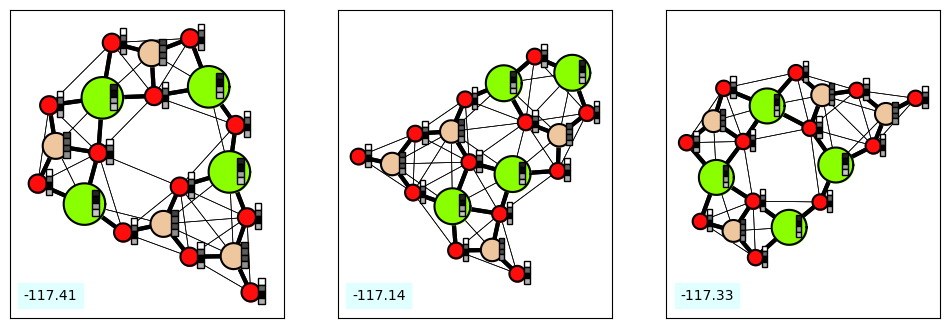

In [8]:
Ncol = 3
fig, axes = plt.subplots(1, Ncol, figsize=(Ncol*4 ,4))

for i in range(Ncol):
    graph = get_graph(i)
    plot_graph(axes[i], graph)

In [9]:
class PhiPsiGNN(MessagePassing):
    def __init__(self, d_in, d_out, d_message=None, aggr='add'):
        super().__init__(aggr=aggr)
        if d_message is None:
            d_message = d_in
        self.psi = torch.nn.Linear(d_in, d_message, bias=True)
        self.phi = torch.nn.Linear(d_message+d_in, d_out, bias=True)
        self.activation = torch.nn.SiLU()

    def forward(self, x, edge_index, edge_attr):
        aggregated_messages = self.propagate(edge_index, x=x, edge_attr=edge_attr)
        x = self.phi(torch.hstack((x, aggregated_messages)))
        return x

    def message(self, x_j, edge_attr):
        return edge_attr*self.activation(self.psi(x_j))

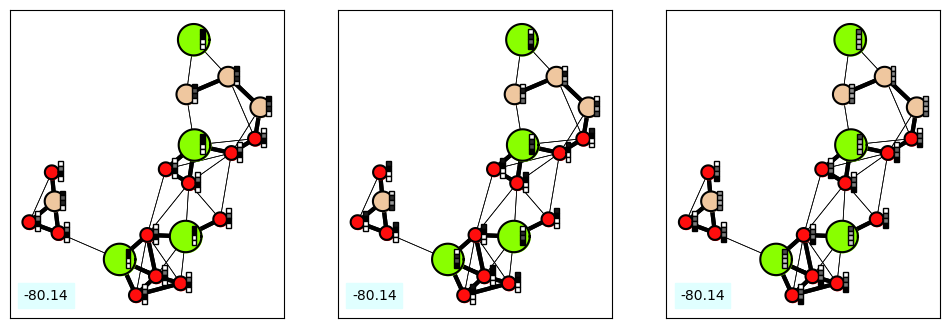

In [10]:
gnn_1 = PhiPsiGNN(embedding_dim, embedding_dim)

graph = get_graph(42)
n_col = 3
fig, axes = plt.subplots(1, n_col, figsize=(12, 4))
for ax in axes:
    plot_graph(ax, graph, val_min=-0.75, val_max=0.25) # val_min and val_max determine the colors for the node attributes
    graph.x = gnn_1(graph.x, graph.edge_index, 2 * graph.edge_attr) # 2 is to enhance effect of message

In [104]:
class MyModel(torch.nn.Module):
    def __init__(self, d_hid1=4, d_hid2=4, d_hid3=4):
        super().__init__()
        self.epochs_trained = 0
        self.mp1 = PhiPsiGNN(embedding_dim, d_hid1, d_message=d_hid1)
        self.mp2 = PhiPsiGNN(d_hid1, d_hid2, d_message=d_hid2)
        self.mp3 = PhiPsiGNN(d_hid2, d_hid3, d_message=d_hid3)
        self.mp4 = PhiPsiGNN(d_hid3, embedding_dim, d_message=d_hid1)
        self.fc1 = torch.nn.Linear(embedding_dim,d_hid2)
        self.fc2 = torch.nn.Linear(d_hid2, d_hid2)
        self.fc3 = torch.nn.Linear(d_hid2,1)
        self.aggr = SumAggregation()
        self.acc_func = torch.nn.SiLU()
        
    def forward(self, graph):
        x = self.local_energies(graph)
        x = self.aggr(x, graph.batch)
        return x

    def representation(self, graph):
        x, edge_index, edge_attr = graph.x, graph.edge_index, graph.edge_attr
        x = self.acc_func(self.mp1(x, edge_index, edge_attr))
        x = self.acc_func(self.mp2(x, edge_index, edge_attr))
        x = self.acc_func(self.mp3(x, edge_index, edge_attr))
        x = self.mp4(x, edge_index, edge_attr)
        return x
    
    def local_energies(self, graph):
        x = self.representation(graph)
        x = self.acc_func(self.fc1(x))
        x = self.acc_func(self.fc2(x))
        x = self.fc3(x)
        return x

In [105]:
def train_model(model, train_loader, optimizer, loss_func=torch.nn.MSELoss(), epochs=1000):
    for epoch in range(epochs):
        total_loss = 0
        total_N = 0
        for graphs in train_loader:
            optimizer.zero_grad()
            #print(graphs.y)
            #print(aggr_phi_psi_gnn.forward(graphs.x, graphs.edge_index, graphs.batch)[1])
            loss = loss_func(model.forward(graphs), graphs.y.view(-1,1))
            loss.backward()
            optimizer.step()
            N = len(graphs)
            total_N += N
            total_loss += loss.item() * N

        avg_loss = total_loss / total_N
        if (epoch+1) % 250 == 0:
            print(f'Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}')

In [106]:
train_list = [get_graph(i) for i in range(1905-190)]
test_list = [get_graph(i) for i in range(1905-189, 1905)]
train_loader = DataLoader(train_list, shuffle=True, batch_size=20)

In [107]:
models = [MyModel() for i in range(3)]
i = 0
for model, epochs in zip(models, [100, 1000, 5000]):
    optimizer = torch.optim.Adam(params=model.parameters(), lr=1e-3)
    print(f"Training model {i+1}")
    train_model(model=model, train_loader=train_loader, optimizer=optimizer, epochs=epochs)
    i+=1

Training model 1
Training model 2
Epoch 250/1000, Loss: 0.7895
Epoch 500/1000, Loss: 0.6681
Epoch 750/1000, Loss: 0.6526
Epoch 1000/1000, Loss: 0.5041
Training model 3
Epoch 250/5000, Loss: 1.3655
Epoch 500/5000, Loss: 0.9342
Epoch 750/5000, Loss: 0.6309
Epoch 1000/5000, Loss: 0.6179
Epoch 1250/5000, Loss: 0.6331
Epoch 1500/5000, Loss: 0.5318
Epoch 1750/5000, Loss: 0.5630
Epoch 2000/5000, Loss: 0.5144
Epoch 2250/5000, Loss: 0.4488
Epoch 2500/5000, Loss: 0.3916
Epoch 2750/5000, Loss: 0.3533
Epoch 3000/5000, Loss: 0.3095
Epoch 3250/5000, Loss: 0.2914
Epoch 3500/5000, Loss: 0.3125
Epoch 3750/5000, Loss: 0.3030
Epoch 4000/5000, Loss: 0.2800
Epoch 4250/5000, Loss: 0.2636
Epoch 4500/5000, Loss: 0.2564
Epoch 4750/5000, Loss: 0.2606
Epoch 5000/5000, Loss: 0.2989


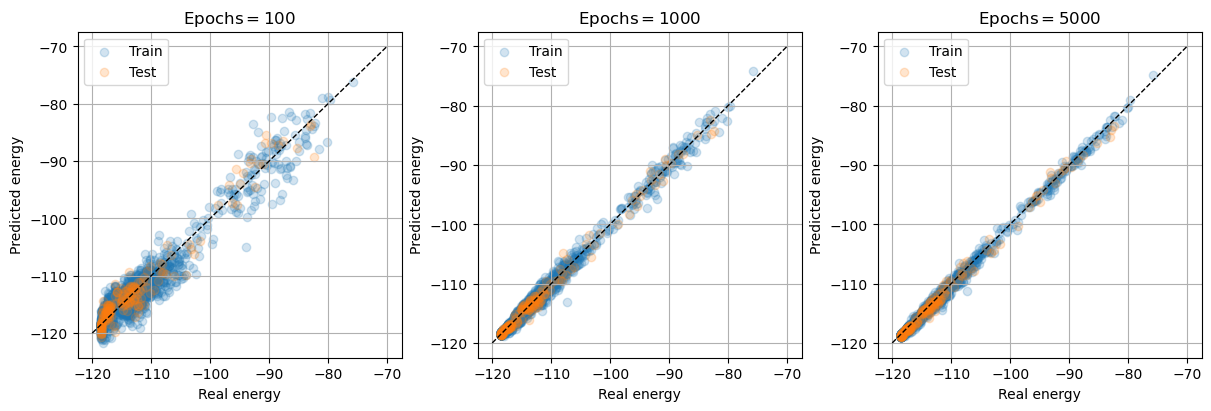

In [110]:
fig, axs = plt.subplots(1,3, figsize=(12,4), layout="constrained")
test_loader = DataLoader(dataset=test_list, batch_size=20)
for model, ax, epochs_num in zip(models, axs, [100, 1000, 5000]):
    ax.set_title(r"Epochs$=$"+f"{epochs_num}")
    ax.grid()
    ax.set_xlabel("Real energy")
    ax.set_ylabel("Predicted energy")
    for i, loader, label in zip(range(2), [train_loader, test_loader], ["Train", "Test"]):
        for j, graphs in enumerate(loader):
            with torch.no_grad():
                pred_E = model.forward(graph=graphs)
                if j == 0:
                    ax.scatter(graphs.y, pred_E, color=f"C{i}", alpha=0.2, label=label)
                else:
                    ax.scatter(graphs.y, pred_E, color=f"C{i}", alpha=0.2)
    xs = np.linspace(-120,-70, 100)
    ax.plot(xs, xs, '--',c="k", lw=1)
    ax.legend()

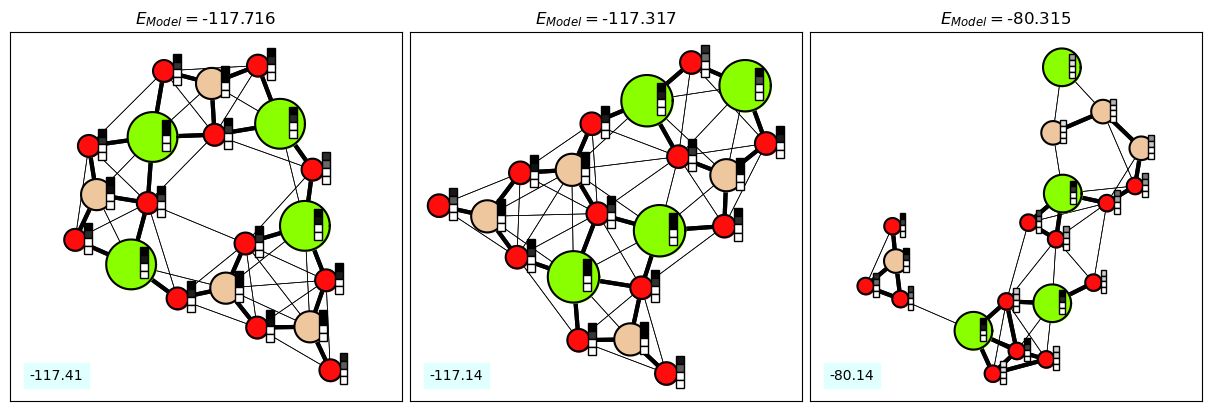

In [112]:
fig, axs = plt.subplots(1,3, figsize=(12,4), layout="constrained")
model = models[-1]
#energies = []
#reps = []
#graphs_tot = []
#for graphs in test_loader:
#    energies.append(model.forward(graphs))
#    reps.append(model.representation(graphs))
#    graphs_tot.append(graphs)
data = np.load('dataset_for_exercise_63/pyroxene.npz')
for i, ax in zip([0, 1, 42], axs):
    #graph = graphs_tot[i][0]
    #rep = reps[i][0]
    #pred_E = energies[i][0]
    graph = get_graph(index=i)
    g = Data(edge_index=graph.edge_index,
         edge_attr=graph.edge_attr, 
         x=model.representation(graph),
         y=graph.y,
         z=graph.z,
         pos=graph.pos)
    plot_graph(ax, g, val_min=-0.75, val_max=0.25)
    with torch.no_grad():
        pred_E = model.forward(graph=graph)
        ax.set_title(r"$E_{Model}=$"+f"{round(pred_E.item(),3)}")